In [30]:
import h5py
import pandas as pd
import numpy as np
from osgeo import gdal
import geopandas as gpd
import rasterio
from rasterio import Affine
from rasterio.transform import from_origin
from shapely.geometry import shape, Point

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm.auto import tqdm
import random
import shutil, os
import gzip

In [17]:
# define the target region
target = 'xinan'
year = '2017_2019'

# sample window
window_size = 512

In [3]:
# read the transformation df
trans_df = pd.read_pickle('./data_cache/tif_df.pkl')
target_meta = trans_df[trans_df['region']==target]['trans'].values[0]
target_meta

{'driver': 'VRT',
 'dtype': 'int16',
 'nodata': None,
 'width': 117948,
 'height': 56932,
 'count': 24,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002694945852358566, 0.0, 78.40810210144626,
        0.0, -0.0002694945852358566, 36.48525492757119)}

### Get traning sample points

In [4]:
# read shp file
China_shp = gpd.read_file('./data_cache/SHP/qu-sheng_dissolved.shp')

# get the target region
target_shp = China_shp[China_shp['region']==target].geometry.values[0]
target_shp

In [5]:
def generate_random_points_in_shp(in_shp, num_points):
    # Open the input shapefile for reading
    min_x, min_y, max_x, max_y = in_shp.bounds

    out_pts = []
    # Generate random points within the bounding box of the polygon
    for _ in range(num_points*3):
        
        random_x = random.uniform(min_x, max_x)
        random_y = random.uniform(min_y, max_y)
        point = Point(random_x, random_y)
            
        # store the point
        out_pts.append(point)

    # spatial filtering to ensure points are inside the shp
    out_pts = gpd.tools.sjoin(gpd.GeoDataFrame({'geometry':out_pts}).set_crs(4326), 
                              gpd.GeoDataFrame({'geometry':[in_shp]}).set_crs(4326), 
                              predicate="within", 
                              how='left').dropna()[['geometry']]

    return out_pts.sample(min(len(out_pts),num_points)).reset_index(drop=True)


<Axes: xlabel='col', ylabel='row'>

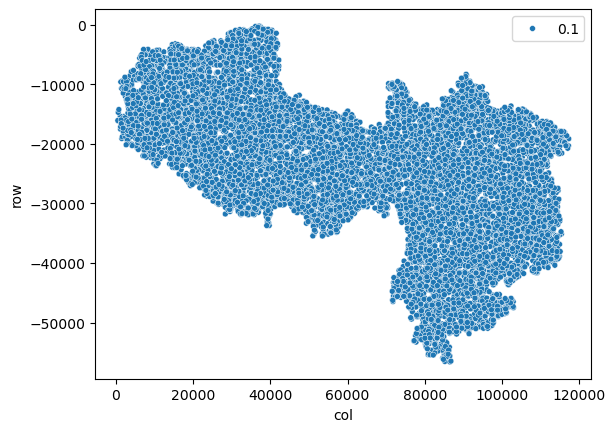

In [6]:
# get the sample points
sample_pt = generate_random_points_in_shp(target_shp, 10000)
sample_pt[['col','row']] = sample_pt['geometry'].apply(lambda geo:~target_meta['transform']*(geo.x,geo.y)).tolist()

# show the row/col
sns.scatterplot(x=sample_pt['col'],y=-sample_pt['row'],size=0.1)

In [37]:
# save the df for loading Y data
time_now = datetime.now()
stamp = f"{time_now.year}_{time_now.month}_{time_now.day}"
sample_pt.to_pickle(f'./data_cache/sample_pts_{target}_{stamp}.pkl')

### Slicing HDF using traning samples

In [7]:
# get all HDF files
hdf_path = r'N:/LUF-Modelling/LUTO2_JZ/Built_map/hdf'
hdf_files = glob(f"{hdf_path}/*.hdf")

# get the target files
target_files = [i for i in hdf_files if ((target in i) and ((year in i) or ('1990_2020' in i)))]

In [8]:
# copy file to local disk
for f in tqdm(target_files):
    if os.path.basename(f) in [os.path.basename(f) for f in glob('./data_cache/*')]:
        print(f"{os.path.basename(f):<50} will use cached file")
        continue
        
    print( f"copying {os.path.basename(f):<50} to cache directory")
    shutil.copyfile(f,f"./data_cache/{os.path.basename(f)}")

# locate local files
local_files = sorted(glob('./data_cache/*.hdf'))

  0%|          | 0/4 [00:00<?, ?it/s]

xinan_Fourier_2017_2019.hdf                        will use cached file
xinan_Landsat_cloud_free_2017_2019.hdf             will use cached file
xinan_NDVI_NDBI_EVI_2017_2019.hdf                  will use cached file
xinan_terrain_1990_2020.hdf                        will use cached file


In [18]:
for hdf in local_files:
    ds = h5py.File(hdf,'r')
    ds = ds[list(ds.keys())[0]]

    # Open the HDF5 file in write mode
    with h5py.File(f'./data_cache/Sample_npy/{os.path.basename(ds.name)}', 'w') as file:

        # loop through points
        for idx,line in tqdm(sample_pt.iterrows(),total=len(sample_pt)):
            row,col = line[['row','row']]
            row,col = int(row),int(col)
            ds_arr = ds[:,
                        row:row+window_size,
                        col:col+window_size,]
            
            # Create datasets and save the NumPy arrays
            file.create_dataset(f'{idx:>08}', data=ds_arr, compression=6)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]